***
# Select desired libraries

In [1]:
# %reset
import ee
import numpy
from matplotlib import pyplot as plot
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
import earthdata as ed

***
# Set Environment for Google Earth Engine (ee)

In [2]:
# Trigger the authentication flow.
# Needed just the first time the API is called.
# ee.Authenticate()

In [3]:
# Adjust libraries to current python version
import collections
collections.Callable = collections.abc.Callable

In [4]:
## Initialize ee library.
ee.Initialize()

***
# Auxiliary Tools

## Define image collection

In [5]:
# Initial date of interest (inclusive).
i_date = '2000-01-01'

# Final date of interest (exclusive).
f_date = '2015-01-01'

# Define point of interest
u_lat = 20.24
u_lon = -103.06
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define area of interest
dx = 0.8
dy = 0.3
rectangle = ee.Geometry.Rectangle([u_lon-dx/2, 
                                  u_lat-dy/2,
                                  u_lon+dx/2,
                                  u_lat+dy/2]) #(xMin, yMin, xMax, yMax)

# Define point of interest
point = ee.Geometry.Point(u_lon, u_lat)

# Define scale
scale = 100  # Scale in meters

# Define working band
band = 'water_mask'

# Create image collection
imageColletion = ee.ImageCollection('MODIS/006/MOD44W')
waterMask = imageColletion.select(band).filterDate(i_date, f_date).filterBounds(rectangle).sort('time')


## Visual representation of a single image

In [6]:
# Define a region of interest with a buffer zone of 1000 km around Lyon.
roi = u_poi.buffer(5e4)
# Reduce the LST collection by mean.
dataset_img = waterMask.first()
# Adjust for scale factor.
scale_factor = 1
dataset_img = dataset_img.select('water_mask').multiply(scale_factor)

from IPython.display import Image

# Create a URL to the styled image for a region around interest point.
url = dataset_img.getThumbUrl({
    'min': 0.0,
    'max': 1.0,
    'dimensions': 512, 
    'region': roi,
    'palette': ['bcba99', '2d0491']})
print(url)

# Display the thumbnail land surface temperature in interest point.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/48acf7ca5f9aacd0b221c87ffd1c89dc-d0af3026a3f09b77dfd831cd5e2501d3:getPixels

Please wait while the thumbnail loads, it may take a moment...


## Image collection visualization with a video

In [7]:
# Define area of interest (aoi)
aoi = rectangle

# Define arguments for animation function parameters.
videoArgs = {
  'dimensions': 512,
  'region': aoi,
  'framesPerSecond': 7,
  'crs': 'EPSG:3857',
  'min': 0,
  'max': 1,
  'palette': ['bcba99', '2d0491']
};

# Alternatively, print a URL that will produce the animation when accessed.
print(waterMask.getVideoThumbURL(videoArgs))

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/b38170a7b4ed1ab270519653b260d5d4-ff0e3eeaacf59f895fab1f342bd5297f:getPixels


## Auxiliary data set

In [8]:
# This dataset was used in the early development stages to test model limitations.
# create dataset
def get_dataset(samples, n_inputs, n_outputs):
    #date, pixel_mask 
    X, y = make_regression(n_samples=samples, n_features=n_inputs, n_informative=10, n_targets=n_outputs, random_state=2)
    return X,y
# summarize shape
# print(X.shape, y.shape)



## Auxiliary Model Evaluator

In [9]:
# Evaluate model to test acfuracy in different scenarios

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = tf.constant(X[train_ix]), tf.constant(X[test_ix])
        y_train, y_test = tf.constant(y[train_ix]), tf.constant(y[test_ix])
        # define model
        model = get_model(n_inputs, n_outputs, 100)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=100)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

***
# Model Development

## Model Definition

In [10]:
def get_model(input_shape, n_outputs, node_numbers):
    hidden_activation_function = 'elu'
    output_activation_function = 'tanh'
    
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(1,)))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(node_numbers, activation=hidden_activation_function))
    model.add(tf.keras.layers.Dense(n_outputs, activation=output_activation_function))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.compile(loss='mean_squared_logarithmic_error', optimizer='adam') # Another viable option for loss function
    return model
# model.summary()

## Model Post-Processing

In [11]:
# Since we only need one out of two values for each pixel, [0 or 1], the model output is normalized and rounded.

def normalize(y_predicted):
    max_val = numpy.max(y_predicted)
    min_val = numpy.min(y_predicted)
    y_predicted_normalized = (y_predicted - min_val) / (max_val - min_val)
    y_predicted_normalized_round = numpy.round(y_predicted_normalized)
    return y_predicted_normalized_round

## Model Use-Case 0: Dummy Dataset

In [12]:
# Run model to check performance

# Define dataset
# n_inputs = 145*451
# n_outputs = 145*451
n_inputs = 1 # date
n_outputs = 145*451 # number of pixles
samples = 10
X, y = get_dataset(samples, n_inputs, n_outputs)

# evaluate model
results = evaluate_model(X, y)

# summarize performance
print('MAE: %.3f (%.3f)' % (numpy.mean(results), numpy.std(results))) # Mean Absolute Error (MAE)

>10555.265
>15015.850
>5.935
>5051.517
>2281.321
>794.642
>2667.564
>3630.344
>538.943
>8815.506
>15015.850
>8815.506
>794.642
>2281.321
>538.943
>5051.517
>10555.265
>2667.564
>5.935
>3630.344
>538.943
>794.642
>8815.508
>15015.850
>2281.321
>5.935
>2667.564
>3630.344
>5051.517
>10555.265
MAE: 4935.689 (4721.565)


## Model Use-Case 1: Square

### Dataset

In [13]:
# Use model for prediction SQUARE
rect_1 = numpy.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

rect_2 = numpy.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

rect_3 = numpy.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

rect_4 = numpy.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]
                  )

y_rect = tf.constant([rect_1.flatten(), rect_2.flatten(), rect_3.flatten(), rect_4.flatten()])
X_rect = [[1],[2],[3],[4]]
y = tf.constant(y_rect)
X = tf.constant(X_rect)

### Model Fit

In [14]:
# Define model inputs and training

n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
# model = get_model(n_inputs, n_outputs)
node_numbers = 100
model = get_model(X.shape, n_outputs, node_numbers)
# fit the model on all data
model.fit(X, y, verbose=0, epochs=200);

In [15]:
# Model Predictions for SQUARES
rows = 16
columns = 16

### Model Prediction Results

1/1 [==============================] - 0s 304ms/step


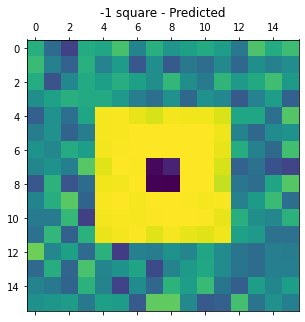

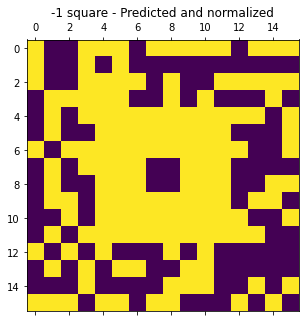

In [16]:
newX = tf.constant([-1])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '-1 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '-1 square - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 16ms/step


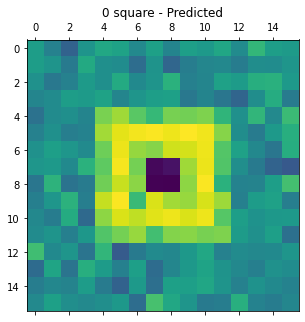

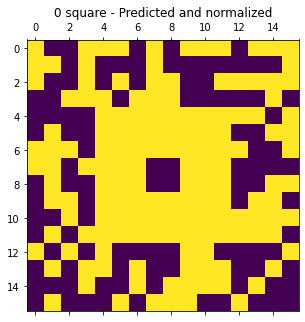

In [17]:
newX = tf.constant([0])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '0 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '0 square - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 15ms/step


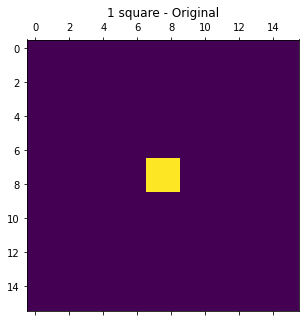

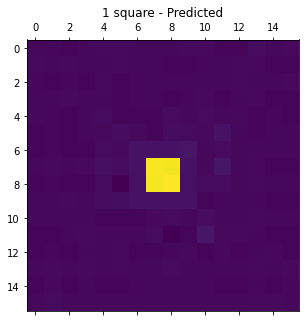

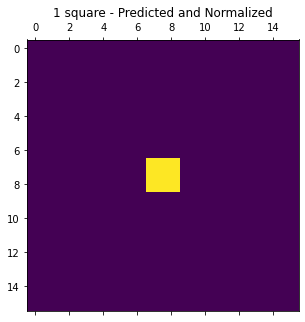

In [18]:
newX = tf.constant([1])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '1 square - Original'
ed.plot_map(rect_1.flatten(), rows, columns, title)

title = '1 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '1 square - Predicted and Normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 12ms/step


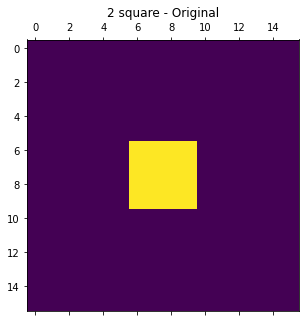

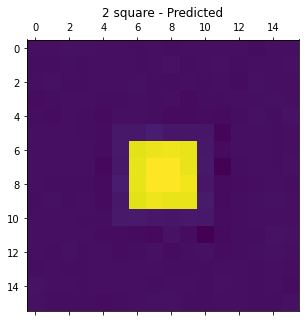

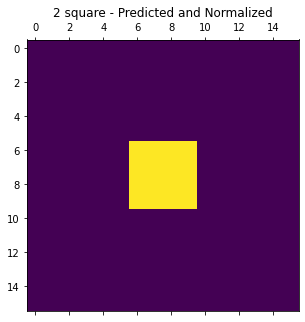

In [19]:
newX = tf.constant([2])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '2 square - Original'
ed.plot_map(rect_2.flatten(), rows, columns, title)

title = '2 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '2 square - Predicted and Normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 13ms/step


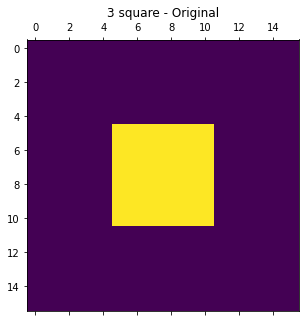

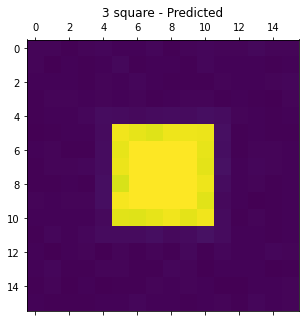

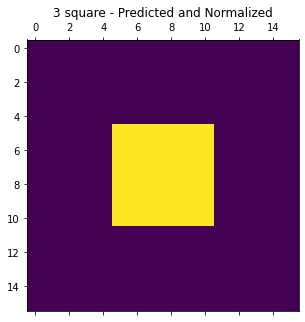

In [20]:
newX = tf.constant([3])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '3 square - Original'
ed.plot_map(rect_3.flatten(), rows, columns, title)

title = '3 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '3 square - Predicted and Normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 15ms/step


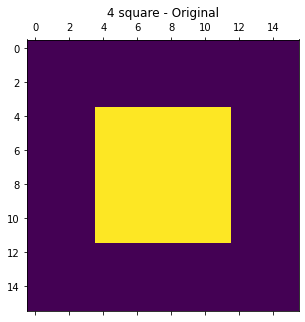

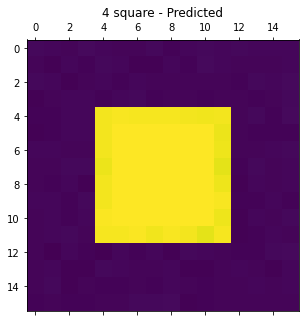

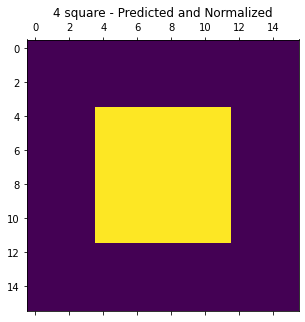

In [21]:
newX = tf.constant([4])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '4 square - Original'
ed.plot_map(rect_4.flatten(), rows, columns, title)

title = '4 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '4 square - Predicted and Normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 18ms/step


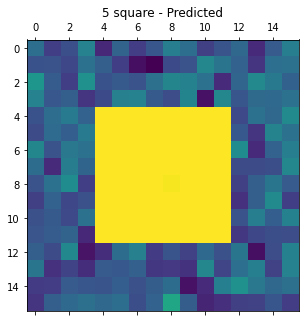

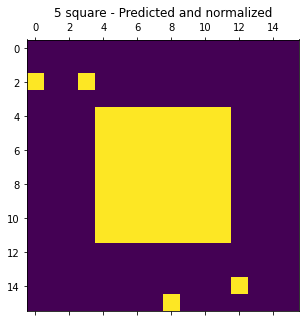

In [22]:
newX = tf.constant([5])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '5 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '5 square - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 16ms/step


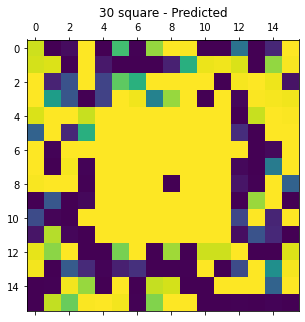

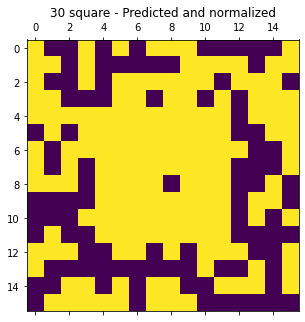

In [23]:
newX = tf.constant([30])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '30 square - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '30 square - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

## Model Use-Case 2: Chapala Lake

### Dataset

In [24]:
# Use model for prediction 

# Clean and divide data for algorithm
# Constant definitions
DATASET_NAME = 'MODIS/006/MOD44W'  # Name of dataset to extract water bodies information
STARTING_DATE = '2000-01-01'  # First element of the dataset
ENDING_DATE = '2015-05-01'  # Last element of the dataset
BAND = 'water_mask'  # Dataset band we are interested in

# User parameters
lat, lon = 20.24, -103.06  # Center coordinates
dx = 0.8  # Rectangle length
dy = 0.3  # Rectangle width

objeto = ed.EarthData()
objeto.select_dataset(DATASET_NAME, STARTING_DATE, ENDING_DATE, BAND)
X, y, rows, columns = objeto.get_dataset(lat, lon, dx, dy)
X = tf.constant(X)-2000
y = tf.constant(y)

n_inputs, n_outputs = X.shape[1], y.shape[1]

### Model Fit

In [25]:
# get model
node_numbers = 1000
model = get_model(n_inputs, n_outputs, node_numbers)
# fit the model on all data
model.fit(X, y, verbose=0, epochs=200)

### Model Prediction Results

1/1 [==============================] - 0s 86ms/step


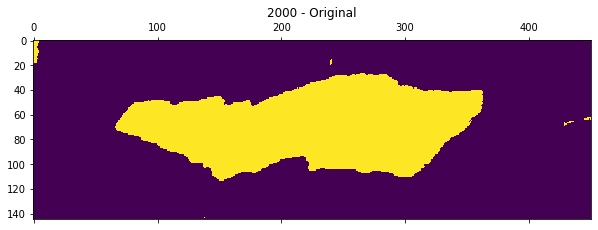

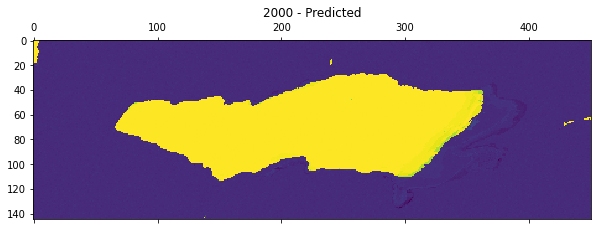

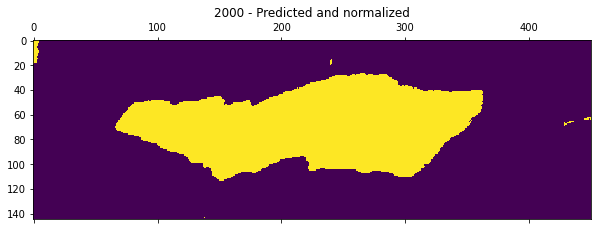

In [26]:
newX = tf.constant([2000-2000])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '2000 - Original'
ed.plot_map(numpy.array(y[2000-2000]).flatten(), rows, columns, title)

title = '2000 - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '2000 - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 58ms/step


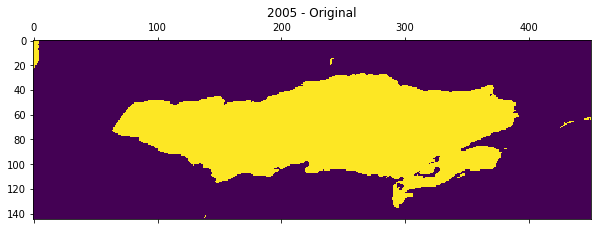

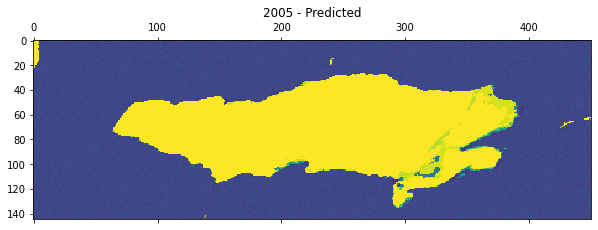

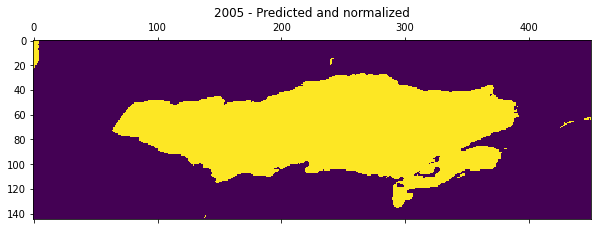

In [27]:
newX = tf.constant([2005-2000])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '2005 - Original'
ed.plot_map(numpy.array(y[2005-2000]).flatten(), rows, columns, title)

title = '2005 - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '2005 - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 62ms/step


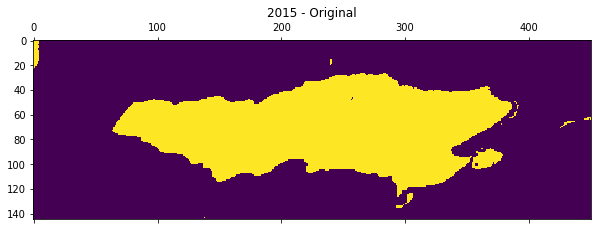

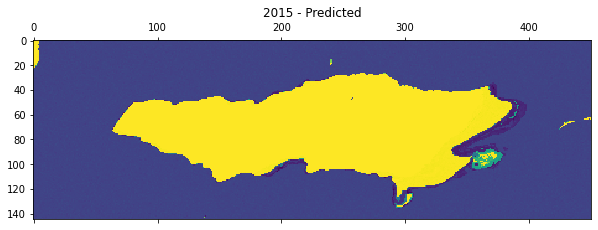

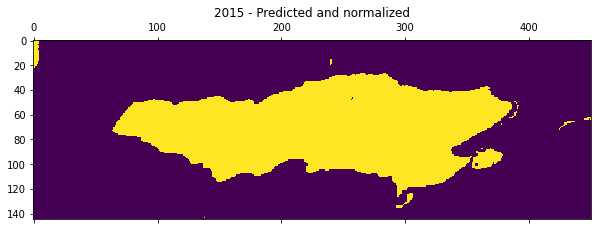

In [28]:
newX = tf.constant([2015-2000])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '2015 - Original'
ed.plot_map(numpy.array(y[2015-2000]).flatten(), rows, columns, title)

title = '2015 - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '2015 - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)

1/1 [==============================] - 0s 65ms/step


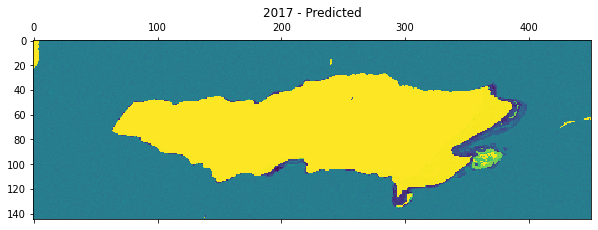

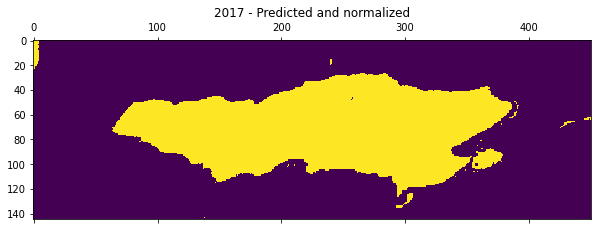

In [29]:
newX = tf.constant([2017-2000])
y_predicted = model.predict(newX)
y_predicted_normalized_round = normalize(y_predicted)

title = '2017 - Predicted'
ed.plot_map(y_predicted, rows, columns, title)

title = '2017 - Predicted and normalized'
ed.plot_map(y_predicted_normalized_round, rows, columns, title)